<a href="https://colab.research.google.com/github/insistedMarin/ML-based-Recommendation-Systems/blob/main/Matrix_Factorization_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls

drive  sample_data


In [5]:
!cd drive/MyDrive/research/

In [2]:
import tensorflow as tf
import pandas as pd

In [22]:
from matplotlib import pyplot as plt

In [3]:
file = pd.read_csv('/content/drive/MyDrive/research/user_item_matrix_1.csv')

In [4]:
rating_df=file[:100000:]

In [5]:
user_count=rating_df[['session']].nunique()
item_count=rating_df[['aid']].nunique()
print(user_count)
print(item_count)
dict_users=rating_df['session'].unique()
dict_users = dict_users.tolist()
len(dict_users)

session    2302
dtype: int64
aid    73139
dtype: int64


2302

In [6]:
dict_items=rating_df['aid'].unique()
len(dict_items)

73139

In [7]:
dict_items = dict_items.tolist()
index = list(range(len(dict_items)))
dict_items_to_index=dict(zip(dict_items,index))
def encode_aid(x):
    return dict_items_to_index[x]


rating_df['aid']=rating_df['aid'].map(encode_aid)
rating_df.head(10)

<ipython-input-7-0aaae983a3e6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['aid']=rating_df['aid'].map(encode_aid)


,Unnamed: 0,session,aid,type
0,0,0,0,1
1,1,0,1,2
2,2,0,2,1
3,3,0,3,1
4,4,0,4,1
5,5,0,5,1
6,6,0,6,1
7,7,0,7,1
8,8,0,8,2
9,9,0,9,1


In [8]:
def build_rating_sparse_tensor(ratings_df):
  indices = ratings_df[['session', 'aid']].values
  values = ratings_df['type'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[int(user_count), int(item_count)])

In [9]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, item_embeddings):
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, item_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss
# def sparse_mean_square_error(sparse_ratings, user_embeddings, item_embeddings):
#   predictions = tf.reduce_sum(
#       tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
#       tf.gather(item_embeddings, sparse_ratings.indices[:, 1]),
#       axis=1)
#   loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
#   return loss

In [10]:
import collections


class CFModel(object):
  def __init__(self, embedding_vars, loss, metrics=None):
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.compat.v1.train.GradientDescentOptimizer):
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.compat.v1.variables_initializer(opt.variables()),
          tf.compat.v1.local_variables_initializer())
      if self._session is None:
        self._session = tf.compat.v1.Session()
        with self._session.as_default():
          self._session.run(tf.compat.v1.global_variables_initializer())
          self._session.run(tf.compat.v1.tables_initializer())
          tf.compat.v1.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [11]:
def split_dataframe(df, holdout_fraction=0.1):
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [12]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "item_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [14]:
tf.compat.v1.disable_eager_execution()

In [17]:
import time

 iteration 5000: train_error=1.843752, test_error=27.109119time cost 6991.330966234207 s


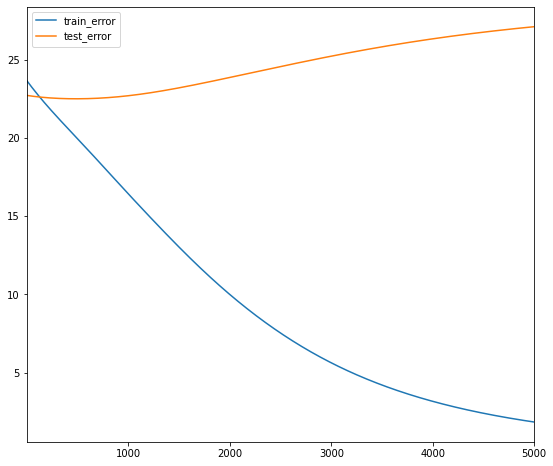

In [23]:
model = build_model(rating_df, embedding_dim=30, init_stddev=0.5)
start= time.time()
model.train(num_iterations=5000, learning_rate=0.5)
end = time.time()
print('time cost',end-start,'s')

In [24]:
import numpy as np

In [25]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [62]:
item_set=rating_df['aid'].map(lambda x : dict_items[x]).unique()

In [65]:
item_set = item_set.tolist()
item_set

[6851,
 7563,
 10268,
 16246,
 30373,
 72748,
 76358,
 97836,
 102416,
 138431,
 154930,
 161938,
 165096,
 166547,
 168206,
 171073,
 171982,
 173702,
 190818,
 218130,
 219033,
 219925,
 240346,
 275288,
 280978,
 294248,
 305831,
 313546,
 315914,
 321397,
 334392,
 337364,
 341626,
 346352,
 351157,
 358305,
 361317,
 362233,
 366890,
 384343,
 394655,
 419161,
 442293,
 461689,
 480578,
 495779,
 504365,
 512756,
 516456,
 528847,
 536842,
 543308,
 570955,
 581169,
 608383,
 624343,
 631008,
 661144,
 667322,
 667924,
 701766,
 702179,
 709417,
 709550,
 719622,
 723612,
 723931,
 724999,
 738987,
 760277,
 784978,
 789245,
 803544,
 823637,
 828625,
 832192,
 843110,
 851778,
 856506,
 859697,
 883849,
 892659,
 915702,
 924751,
 938007,
 946219,
 959208,
 961113,
 964169,
 974651,
 976007,
 976134,
 979517,
 984597,
 1009750,
 1048044,
 1048797,
 1049280,
 1052813,
 1055124,
 1062149,
 1070142,
 1072782,
 1090479,
 1110548,
 1110741,
 1110941,
 1127565,
 1140855,
 1145803,
 115

In [66]:

def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  scores = compute_scores(
        model.embeddings["user_id"][2301], model.embeddings["item_id"], measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'aid': item_set
  })
  if exclude_rated:
    rated_items = rating_df[rating_df.session == "2301"]["aid"].values
    df = df[df.aid.apply(lambda aid: aid not in rated_items)]
  display.display(df.sort_values([score_key], ascending=False).head(k))  

In [68]:
from IPython import display

In [69]:
user_recommendations(model, measure=COSINE, k=5)

,cosine score,aid
73112,0.704997,586945
63531,0.684051,1088873
48145,0.661742,1482108
37404,0.641064,1821829
7605,0.623335,253268


In [74]:
user_recommendations(model, measure=DOT, k=5)

,dot score,aid
6028,13.236178,1293949
9388,12.609770,1647563
8573,9.564992,1378087
43551,9.257178,393073
73112,8.300262,586945


In [71]:
def item_neighbors(model, item_aid, measure=DOT, k=6):
  id=dict_items_to_index[item_aid]
  scores = compute_scores(
      model.embeddings["item_id"][id], model.embeddings["item_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'aid': item_set,
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [72]:
last_aid=item_set[10]
last_aid

154930

In [73]:
item_neighbors(model, last_aid, DOT)
item_neighbors(model, last_aid, COSINE)

,dot score,aid
26039,8.092097,1796601
4997,7.489398,148534
10,7.182528,154930
23569,5.836050,835010
15752,5.671343,372708
62833,5.510988,274014


,cosine score,aid
10,1.000000,154930
55976,0.682462,1279732
19832,0.639524,5108
62067,0.631948,620136
55309,0.607958,1311153
54070,0.606172,314393
